Добрый день.

Многоклассовая классификация

1. загрузите из sklearn датасет с цифрами (каждый элемент кодирует изображение цифры размером 8х8)
2. Осмотрите данные и метки.
3. попробуйте отобразить любое единичное изображение из набора с помощью matplotlib.
4. Примените тетрадку с прошлого урока к загруженному датасету в части многоклассовой классификации. 
5. Рассмотрите матрицу неточностей, сделайте выводы какие цифры классификатор принимает за другие наиболее часто.
6. Сравните качество стратегий OvR и OvO.


Логистическая регрессия

1. Возьмите датасет с данными по телефонной компании с прошлых уроков.
2. Подготовьте данные для обучения.
3. Нормализуйте данные с помощью MinMaxScaler (рассматривали в конце прошлого урока)
4. Обучите логистическую регрессию на нормированных данных.
5. Посчитайте метрики на тестовом и обучающем множествах.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, \
              recall_score, f1_score

Многоклассовая классификация

Загрузим данные.

In [38]:
data = load_digits()

In [39]:
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [40]:
data.data.shape

(1797, 64)

Данные представлят собой словарь с ключами.
 - data - сами данные. Матрица. 1797 строк. 64 столбца. В строку выписаны по порядку значения из сетки начиная с первой строки. 
 Само изоржение однослойное  таком случае.
 - target - вектор знчений. Содержит "ответ" - то, что закодировано в изображении
 - images - трехмерный массив изображений. содержит 1797 матриц 8*8.

По другим ключам по существу интересного ничего нет...

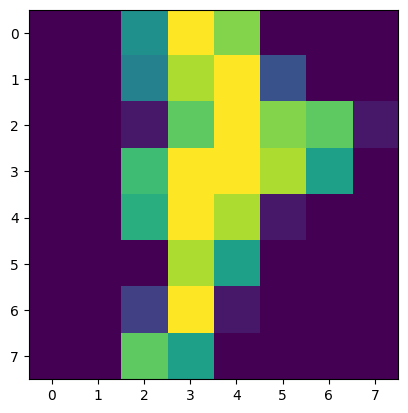

In [41]:
plt.imshow(data.images[211]);

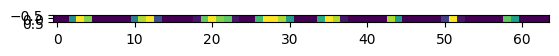

In [42]:
plt.imshow(data.data[211].reshape(1, -1));

In [43]:
data.target[211]

7

Слабо похоже, но это 7...

<AxesSubplot:>

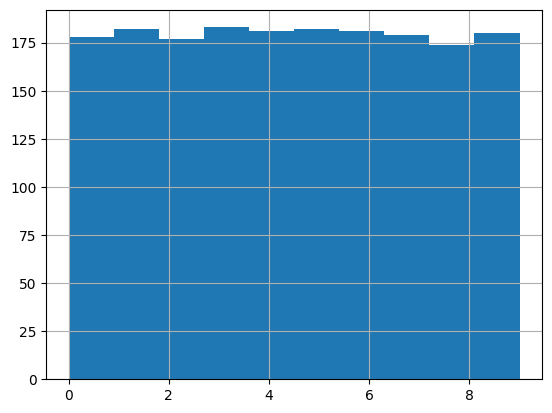

In [44]:
pd.Series(data.target).hist()

Все данные валидны и их много. Перекоса в классах у нас нет, что также хорошо

Разделим на тренировочную и тестовую выборки в соотношении 80/20.

In [45]:
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.8, random_state=1)

Поработаем с этими данными многоклассовым классификатором SGD с применением стратегий OvO и OvR.

In [46]:
ovoSGD = OneVsOneClassifier(SGDClassifier(random_state=1))
ovrSGD = SGDClassifier(random_state=1)

In [47]:
ovoSGD.fit(x_train, y_train)
ovrSGD.fit(x_train, y_train);

Вычислим точность обоих классификаторов

In [48]:
ovoSGD.score(x_test, y_test), ovrSGD.score(x_test, y_test)

(0.9123783031988874, 0.9304589707927677)

In [49]:
ovo_pred, ovr_pred = ovoSGD.predict(x_test), ovrSGD.predict(x_test)

Результат немного лучше у OvR классификатора.

Вычислим precision, recall и f1 скор

In [50]:
precision_score(y_test, ovo_pred, average = 'macro'), recall_score(y_test, ovo_pred, average = 'macro'), f1_score(y_test, ovo_pred, average = 'macro') 

(0.9177022020442983, 0.9127177906946363, 0.9134691745994008)

In [51]:
precision_score(y_test, ovr_pred, average = 'macro'), recall_score(y_test, ovr_pred, average = 'macro'), f1_score(y_test, ovr_pred, average = 'macro') 

(0.9319394461552551, 0.9302410279383915, 0.9304781684040044)

Снова же все результаты у OvR классификатора лучше

Посмотрим на матрицу неточностей. Сразу занулим главную диагональ. Она не информативна, т.к. точность у классификаторов довольно высокая.

In [52]:
ovo_cm, ovr_cm = confusion_matrix(y_test, ovo_pred), confusion_matrix(y_test, ovr_pred)
np.fill_diagonal(ovo_cm, 0)
np.fill_diagonal(ovr_cm, 0)

Опытным путём установлено (при передаче функции аргумента labels), что подписи соответствуют самим числам, а в документации сказано, что по вертикали в шапке записаны предсказания модели, а по горозинтали - истинные значения.

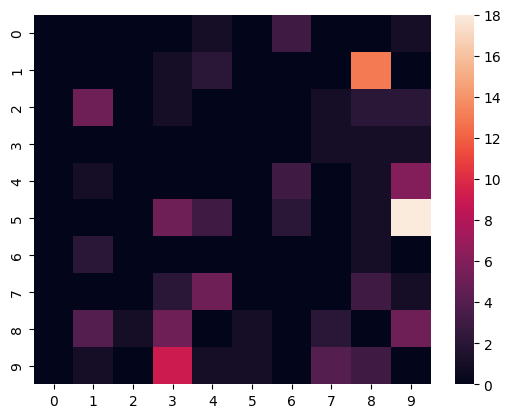

In [53]:
sns.heatmap(ovo_cm);

In [54]:
ovo_cm

array([[ 0,  0,  0,  0,  1,  0,  3,  0,  0,  1],
       [ 0,  0,  0,  1,  2,  0,  0,  0, 13,  0],
       [ 0,  5,  0,  1,  0,  0,  0,  1,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1],
       [ 0,  1,  0,  0,  0,  0,  3,  0,  1,  6],
       [ 0,  0,  0,  5,  3,  0,  2,  0,  1, 18],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  2,  5,  0,  0,  0,  3,  1],
       [ 0,  4,  1,  5,  0,  1,  0,  2,  0,  5],
       [ 0,  1,  0,  9,  1,  1,  0,  4,  3,  0]], dtype=int64)

Опишем три самых ярких пятна на тепловой матрице:

1. В 18 случаях модель давала предсказние 9 при факте 5.
2. В 13 случаях модель давала предсказние 8 при факте 1.
3. В 9 случаях модель давала предсказние 3 при факте 9.

In [55]:
ovr_cm

array([[ 0,  0,  0,  0,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  5,  0,  0,  0,  3,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  2,  2,  0],
       [ 0,  2,  3,  0,  0,  2,  0,  4,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1],
       [ 1,  1,  1,  2,  0,  0,  1,  1,  0,  7],
       [ 0,  4,  0,  0,  1,  1,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  1,  0],
       [ 0, 12,  1,  3,  0,  3,  0,  2,  0,  3],
       [ 0,  3,  0,  1,  0,  1,  0,  4,  4,  0]], dtype=int64)

У OvR классификатора ошибок ожидаемо меньше. Хотя он стал больше ошибаться и давать ответ 8 при факте 9.

В целом классификатор OvR дал лучший результат.

Логистическая регрессия

Прочитаем данные.

In [56]:
df_train = pd.read_csv("churn-bigml-80.csv")
df_test = pd.read_csv("churn-bigml-20.csv")

In [57]:
df_train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Сразу заменим некоторые типы данных на числовые. Понизим разрядность чисел для уменьшения объема памяти

In [58]:
for df in df_train, df_test:
    df["International plan"] = df["International plan"].map({"Yes": 1, "No": 0})
    df["Voice mail plan"] = df["Voice mail plan"].map({"Yes": 1, "No": 0})
    df["Churn"] = df["Churn"].map({True: 1, False: 0})

    for col in (['Account length', 'Area code', 'International plan',
                'Voice mail plan', 'Number vmail messages',
                'Total day calls', 'Total eve calls', 'Total night calls', 
                'Total intl calls', 'Customer service calls', 
                'Customer service calls', 'Churn']):
        df[col] = df[col].astype("int32", copy=False)

    for col in (['Total day minutes', 'Total day charge', 
                'Total eve minutes', 'Total eve charge', 
                'Total night minutes', 'Total night charge', 
                'Total intl minutes', 'Total intl charge']):
        df[col] = df[col].astype("float32", copy=False)

C:\Users\Николай\AppData\Local\Temp\ipykernel_6568\1494525298.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr());


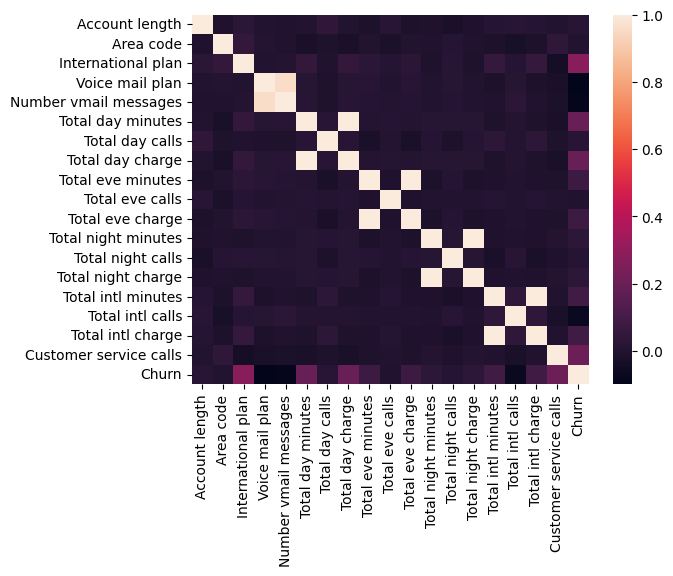

In [59]:
sns.heatmap(df_train.corr());

Из-за высокой корреляции между собой дропнем колонки:
 - 'Number vmail messages'
 - 'Total day minutes'
 - 'Total eve minutes'
 - 'Total night minutes'
 - 'Total intl minutes'

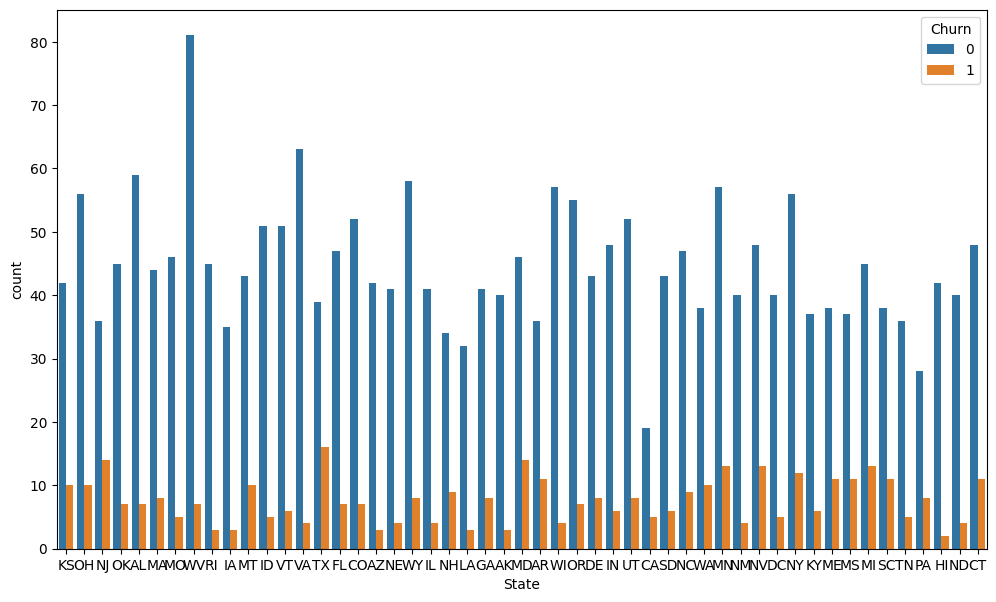

In [60]:
sns.countplot(x = "State", hue="Churn", data=df_train)
plt.gcf().set_size_inches(12, 7);

Дропнем колонку со штатом. Ну её...

In [61]:
for df in df_train, df_test:
    df.drop(['Number vmail messages', 
             'Total day minutes',
             'Total eve minutes',
             'Total night minutes',
             'Total intl minutes',
             'State'], axis=1, inplace=True)

In [62]:
df_train.head()

,Account length,Area code,International plan,Voice mail plan,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,110,45.070000,99,16.780001,91,11.01,3,2.70,1,0
1,107,415,0,1,123,27.469999,103,16.620001,103,11.45,3,3.70,1,0
2,137,415,0,0,114,41.380001,110,10.300000,104,7.32,5,3.29,0,0
3,84,408,1,0,71,50.900002,88,5.260000,89,8.86,7,1.78,2,0
4,75,415,1,0,113,28.340000,122,12.610000,121,8.41,3,2.73,3,0


Теперь данные готовы для обучения логистической регрессии

In [63]:
x_train, y_train = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1:]]
x_test, y_test = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1:]]

Проскалируем их

In [64]:
min_max = MinMaxScaler()

In [65]:
min_max.fit(x_train)

MinMaxScaler()

In [66]:
x_train_scaled = min_max.transform(x_train)
x_test_scaled = min_max.transform(x_test)

Натренируем регрессию

In [67]:
logReg = LogisticRegression(random_state=1)

In [68]:
logReg.fit(x_train_scaled, y_train);

c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
logReg.score(x_test_scaled, y_test)

0.8575712143928036

In [70]:
pred = logReg.predict(x_test_scaled)

In [71]:
precision_score(y_test, pred, average = 'macro'), recall_score(y_test, pred, average = 'macro'), f1_score(y_test, pred, average = 'macro') 

(0.6860374414976599, 0.5570574162679426, 0.5682789068834186)

(0.7048919068736141, 0.5272083179977917, 0.5183301579497266)

Вот такой результат был у меня на непроскалированных данных... скалирование сделало лучше f1 скор, но не вау...

Упала точность, выросла полнота. Это значит, что мы стали лучше детектить всех уходящих абонентов, но при этом стали называть уходящими больше неуходящих клиентов. Наверное, в конкретной задаче это важнее, поэтому подходяще)

***Добавил матрицу неточностей

In [72]:
confusion_matrix(y_test, pred)

array([[559,  13],
       [ 82,  13]], dtype=int64)